<a href="https://colab.research.google.com/github/JunsolKim/explicit_als/blob/main/explicit_als.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, diags
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

np.random.seed(42)

# Load MovieLens 1M data

In [ ]:
!wget -O ml-1m.zip https://files.grouplens.org/datasets/movielens/ml-1m.zip

In [ ]:
le_user = LabelEncoder()
le_item = LabelEncoder()

df = pd.read_csv('./ml-1m/ratings.dat', names=['user', 'item', 'rating', 'time'], header=None, sep='::')
df['userid'] = le_user.fit_transform(df.user)
df['itemid'] = le_item.fit_transform(df.item)

In [105]:
train, test = train_test_split(df, train_size=0.9)

In [106]:
# Create an explicit feedback matrix
ratings = csr_matrix((train.rating, (train.userid, train.itemid)), shape=(train.userid.max()+1, train.itemid.max()+1))

# Define the matrix factorization model

In [107]:
class ExplicitALS():
    def fit(self, ratings, n_factors=20, r_lambda=0.01, n_iter=15):
        """
        Train a matrix factorization model to predict empty 
        ratings (explicit ratings) in a matrix.
        
        User latent factors (X) and item latent factors (Y) 
        are created.
        
        Parameters
        ----------
        ratings: (scipy.sparse.csr_matrix)
            
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model. The default is 20.
        r_lambda : (float)
            Regularization term for user and item latent factors. 
            The default is 0.01.
        n_iter : (int)
            The number of iterations. The default is 15.
        """
        self.ratings = ratings
        self.C = (ratings > 0).astype(int)
        self.n_users = ratings.shape[0]
        self.n_items = ratings.shape[1]
        self.n_factors = n_factors
        self.r_lambda = r_lambda

        # initialize latent vectors with small values
        X = np.random.normal(scale=1./self.n_factors, size=(self.n_users, self.n_factors))
        Y = np.random.normal(scale=1./self.n_factors, size=(self.n_items, self.n_factors))
        
        for i in range(n_iter):
            print(f"Epoch {i}:")
            X = self._optimize_user(X, Y)
            Y = self._optimize_item(X, Y)
        self.X = X
        self.Y = Y

    def _optimize_user(self, X, Y):
        # optimize user latent factors
        lambda_I = self.r_lambda * np.identity(self.n_factors)
        for u in tqdm(range(self.n_users)):
            cU = diags(self.C[u].todense().A1)
            pU = self.ratings[u, :].todense().A1
            yT_cU = cU.T.dot(Y).T # Y.T.dot(cU)
            yT_cU_y = yT_cU.dot(Y)
            yT_cU_pU = yT_cU.dot(pU)
            X[u] = np.linalg.solve(yT_cU_y + lambda_I, yT_cU_pU)
        return X
    
    def _optimize_item(self, X, Y):
        # optimize item latent factors
        lambda_I = self.r_lambda * np.identity(self.n_factors)
        for i in tqdm(range(self.n_items)):
            cI = diags(self.C[:, i].todense().A1)
            pI = self.ratings[:, i].todense().A1
            xT_cI = cI.T.dot(X).T # Y.T.dot(CI)
            xT_cI_x = xT_cI.dot(X)
            xT_cI_pI = xT_cI.dot(pI)
            Y[i] = np.linalg.solve(xT_cI_x + lambda_I, xT_cI_pI)
        return Y

In [108]:
als = ExplicitALS()

In [ ]:
als.fit(ratings)

# Predictions

In [112]:
# each element is a predicted rating of user u on item i
predictions = als.X.dot(als.Y.T) 

In [121]:
test_predictions = predictions[test.userid, test.itemid]
test_observations = test.rating
results = pd.DataFrame({'test_predictions': test_predictions, 
                        'test_observations': test_observations})
results.loc[results.test_predictions < 1, 'test_predictions'] = 1 # apply caps to fix the range
results.loc[results.test_predictions > 5, 'test_predictions'] = 5

In [114]:
pearsonr(test_observations, test_predictions)

(0.519139199638336, 0.0)

In [115]:
mean_squared_error(test_observations, test_predictions)

1.1382467256672115

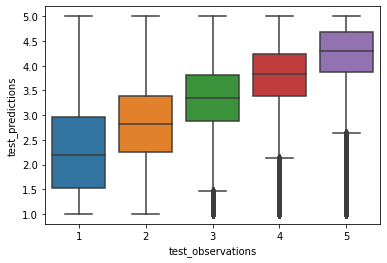

In [125]:
import seaborn as sns
sns.boxplot(x='test_observations', y='test_predictions', data=results)